# Optimización del modelo $f(x,y)=\cos(x)\,\sin(y) - \dfrac{x}{y^2+1}$

**Métodos implementados**: Máximo descenso y Newton amortiguado.  
Incluye comparación y graficación.


### Problema irrestricto vs. restringido a caja

En el **irrestricto**, nuestra $f$ *no* tiene mínimo global: en $y=0$, $f(x,0)=-x\to -\infty$. Con Armijo sigue encontrando pasos que bajan $f$ y no aterriza.

En la **caja** $[-100,100]^2$ (problema restringido) el mínimo *existe* (Weierstrass). Sin embargo, como $f$ es no convexa, descenso/Newton sólo garantizan llegar a puntos *KKT* (locales) y no al global. De hecho, en esta función el mínimo global está en el borde ($x=100$, $y\approx 0$), pero hay muchos estacionarios interiores con $f\approx -1$. 

In [20]:

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Dict, Any
import pandas as pd

# --- Modelo ---
def f_xy(x: float, y: float) -> float:
    return np.cos(x) * np.sin(y) - x / (y**2 + 1.0)

def grad_xy(xy: np.ndarray) -> np.ndarray:
    x, y = xy
    df_dx = -np.sin(x) * np.sin(y) - 1.0 / (y**2 + 1.0)
    df_dy = np.cos(x) * np.cos(y) + (2.0 * x * y) / (y**2 + 1.0)**2
    return np.array([df_dx, df_dy], dtype=float)

def hess_xy(xy: np.ndarray) -> np.ndarray:
    x, y = xy
    f_xx = -np.cos(x) * np.sin(y)
    f_xy_val = -np.sin(x) * np.cos(y) + (2.0 * y) / (y**2 + 1.0)**2
    f_yy = -np.cos(x) * np.sin(y) + 2.0 * x * (1.0 - 3.0 * y**2) / (y**2 + 1.0)**3
    return np.array([[f_xx, f_xy_val],
                     [f_xy_val, f_yy]], dtype=float)

def f_vec(xy: np.ndarray) -> float:
    return f_xy(xy[0], xy[1])


## Auxiliares: Búsqueda en línea de **Armijo**

In [21]:

@dataclass
class ArmijoParams:
    c: float = 1e-4
    rho: float = 0.5
    alpha0: float = 1.0
    max_backtracks: int = 50

def backtracking_armijo(x: np.ndarray, d: np.ndarray, grad: np.ndarray,
                        f: Callable[[np.ndarray], float], params: ArmijoParams):
    alpha = params.alpha0  # paso inicial para el retroceso de Armijo
    fx = f(x)  # valor actual de la función en x_k
    gTd = float(grad @ d)  # producto interno grad^T d (debe ser negativo si d es de descenso)
    bt_steps = 0
    while f(x + alpha * d) > fx + params.c * alpha * gTd and bt_steps < params.max_backtracks:  # reduce alpha hasta cumplir la condición de Armijo: si no hay descenso suficiente, reducimos alpha
        alpha *= params.rho # retroceso: encoge el paso multiplicando por rho (0<rho<1)
        bt_steps += 1
    return alpha, bt_steps

## Algoritmos implementados

In [22]:
import numpy as np 

_LO, _HI = -100.0, 100.0  # Límites inferior y superior de la caja por componente

def _clip_box(x):
    return np.minimum(np.maximum(np.asarray(x, float), _LO), _HI)  # Proyección simple a la caja: recorta cada coordenada

def _gproj_inf_norm(x, g, eps=1e-12):
    x = np.asarray(x, float); g = np.asarray(g, float) 
    pg = g.copy()  # Gradiente proyectado (se anulan componentes no permitidas por la caja)
    for i in range(len(x)):
        if x[i] >= _HI - eps and pg[i] < 0: pg[i] = 0.0  # En borde superior, no empujar hacia fuera (negativo)
        if x[i] <= _LO + eps and pg[i] > 0: pg[i] = 0.0  # En borde inferior, no empujar hacia fuera (positivo)
    return float(np.max(np.abs(pg)))  

def max_descent(x0, tol=5e-6, max_iters=1000, alpha0=1.0, armijo_c=1e-4, armijo_rho=0.5):
    try:
        RunResult 
    except NameError:
        from dataclasses import dataclass, field 
        from typing import Tuple, List  # Tipado de campos
        @dataclass
        class RunResult:
            method: str  # Nombre del método
            start: Tuple[float,float]  # Punto inicial
            steps: int  # Iteraciones realizadas
            func_val: float  # Valor final de f
            grad_norm: float  # ||gradiente proyectado||_inf final
            success: bool  # Éxito si grad_norm <= tol
            alpha0: float  # Paso inicial usado
            path: List[Tuple[float,float]] = field(default_factory=list)  # Trayectoria de puntos
            backtracks: List[int] = field(default_factory=list)  # Backtracks por iteración

    x = _clip_box(x0)  # Asegura que el inicio esté dentro de la caja
    path, bts = [tuple(x)], []  # Inicializa trayectoria y lista de backtracks
    for k in range(int(max_iters)):
        g = grad_xy(x)  
        if _gproj_inf_norm(x, g) <= tol:  # Paro por KKT 
            break
        d = -g  # Dirección de descenso más pronunciado
        fx = f_vec(x)  # Valor actual de la función
        alpha, bt = float(alpha0), 0  # Paso inicial y contador de backtracks
        while True:
            x_trial = _clip_box(x + alpha*d)  # Propone paso y proyecta a la caja
            s = x_trial - x 
            if float(f_vec(x_trial)) <= fx + armijo_c * float(np.dot(g, s)):
                break  
            alpha *= armijo_rho; bt += 1 
            if bt > 30: break 
        bts.append(bt)  # Registra backtracks de esta iteración
        if np.allclose(x_trial, x): break  
        x = x_trial; path.append(tuple(x))  # Actualiza punto y guarda en trayectoria

        g = grad_xy(x)  # Recalcula gradiente tras moverse
        for _ in range(2):
            if np.isclose(x[0], _HI, atol=1e-9) or np.isclose(x[0], _LO, atol=1e-9):
                d1 = np.array([0.0, -g[1]])  # Si x está activo, ajusta sólo y
            elif np.isclose(x[1], _HI, atol=1e-9) or np.isclose(x[1], _LO, atol=1e-9):
                d1 = np.array([-g[0], 0.0])  # Si y está activo, ajusta sólo x
            else:
                break  
            fx = f_vec(x); a = alpha0; bt1 = 0 
            while True:
                x_try = _clip_box(x + a*d1)  # Paso d1 y proyección
                s = x_try - x 
                if float(f_vec(x_try)) <= fx + armijo_c * float(np.dot(g, s)): 
                    x = x_try; path.append(tuple(x)); break 
                a *= armijo_rho; bt1 += 1  
                if bt1 > 20: break  

    gfin = grad_xy(x)  # Gradiente final
    return RunResult("MaxDesc(box)", tuple(np.asarray(x0,float)), len(path)-1, float(f_vec(x)), _gproj_inf_norm(x,gfin), _gproj_inf_norm(x,gfin)<=tol, float(alpha0), path, bts) 

def newton_method(x0, tol=5e-6, max_iters=200, alpha0=1.0, armijo_c=1e-4, armijo_rho=0.5):
    try:
        RunResult  
    except NameError:
        from dataclasses import dataclass, field  
        from typing import Tuple, List  
        @dataclass
        class RunResult:
            method: str  # Nombre del método
            start: Tuple[float,float]  # Punto inicial
            steps: int  # Iteraciones realizadas
            func_val: float  # Valor final de f
            grad_norm: float  # ||gradiente proyectado||_inf final
            success: bool  # Éxito si grad_norm <= tol
            alpha0: float  # Paso inicial usado
            path: List[Tuple[float,float]] = field(default_factory=list)  # Trayectoria
            backtracks: List[int] = field(default_factory=list)  # Backtracks por iteración

    x = _clip_box(x0)  # Proyección inicial a la caja
    path, bts = [tuple(x)], []  # Inicializa trayectoria y backtracks
    for k in range(int(max_iters)):
        g = grad_xy(x)  # Gradiente actual
        if _gproj_inf_norm(x, g) <= tol:  # Paro por KKT 
            break
        H = hess_xy(x)  # Hessiana actual
        try:
            d = -np.linalg.solve(H, g)  # Dirección de Newton resolviendo H d = -g
            if float(np.dot(g, d)) >= 0: d = -g  # Salvaguarda: fuerza dirección de descenso
        except Exception:
            d = -g  
        fx = f_vec(x)  # Valor actual de la función
        alpha, bt = float(alpha0), 0  
        while True:
            x_trial = _clip_box(x + alpha*d)  # Aplica paso y proyecta
            s = x_trial - x  # Salto aplicado
            if float(f_vec(x_trial)) <= fx + armijo_c * float(np.dot(g, s)): 
                break  
            alpha *= armijo_rho; bt += 1  
            if bt > 30: break  
        bts.append(bt)  # Registra backtracks
        if np.allclose(x_trial, x): break  
        x = x_trial; path.append(tuple(x)) 

        g = grad_xy(x)  # Gradiente tras moverse
        for _ in range(2):
            if np.isclose(x[0], _HI, atol=1e-9) or np.isclose(x[0], _LO, atol=1e-9):
                d1 = np.array([0.0, -g[1]])  # Ajuste sólo en y si x está activo
            elif np.isclose(x[1], _HI, atol=1e-9) or np.isclose(x[1], _LO, atol=1e-9):
                d1 = np.array([-g[0], 0.0])  # Ajuste sólo en x si y está activo
            else:
                break  
            fx = f_vec(x); a = alpha0; bt1 = 0 
            while True:
                x_try = _clip_box(x + a*d1) 
                s = x_try - x  # Salto 1D
                if float(f_vec(x_try)) <= fx + armijo_c * float(np.dot(g, s)): 
                    x = x_try; path.append(tuple(x)); break 
                a *= armijo_rho; bt1 += 1 
                if bt1 > 20: break 

    gfin = grad_xy(x) 
    return RunResult("Newton(box)", tuple(np.asarray(x0,float)), len(path)-1, float(f_vec(x)), _gproj_inf_norm(x,gfin), _gproj_inf_norm(x,gfin)<=tol, float(alpha0), path, bts)  


## Graficación del modelo

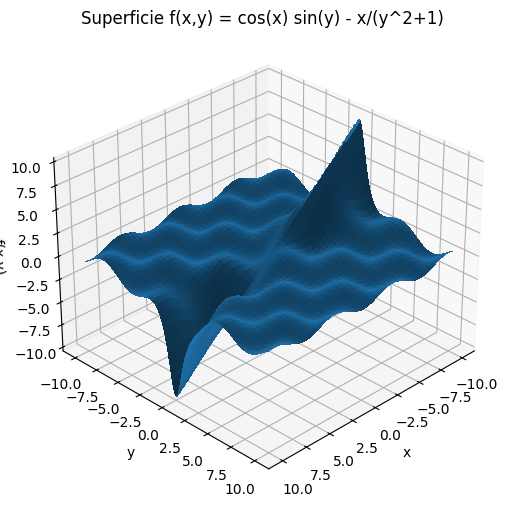

In [23]:
def plot_surface(xmin=-10, xmax=10, ymin=-10, ymax=10, num=200, elev=30, azim=45):
    xs = np.linspace(xmin, xmax, num)
    ys = np.linspace(ymin, ymax, num)
    X, Y = np.meshgrid(xs, ys, indexing="xy")  # malla regular en [xmin,xmax] x [ymin,ymax]
    Z = np.cos(X) * np.sin(Y) - X / (Y**2 + 1.0) # evaluamos z = f(x,y) sobre la malla
    from mpl_toolkits.mplot3d import Axes3D 
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)  # dibujamos la superficie 3D
    ax.set_title("Superficie f(x,y) = cos(x) sin(y) - x/(y^2+1)")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("f(x,y)")
    ax.view_init(elev=elev, azim=azim)  # configuramos la cámara (elevación y azimut)
    plt.show()

    
# Ejemplo de graficación 
plot_surface(xmin=-10, xmax=10, ymin=-10, ymax=10, num=150)


## Casos de prueba y comparación

In [24]:
import json
import numpy as np

INPUT_JSON = "casos_prueba.json"
OUT_GD     = "resultados_gd.json"       # resultados de gradiente
OUT_NT     = "resultados_newton.json"   # resultados de Newton
OUT_BEST   = "resultados_mejor.json"    # mejor f entre ambos por caso/alpha0

with open(INPUT_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

starts = data["starts"]
alpha0_list = data["alpha0_list"]

gd_rows = []
nt_rows = []

for start in starts:
    x0 = np.array(start, float)
    for a0 in alpha0_list:
        r_gd = max_descent(x0, tol=5e-6, max_iters=1000, alpha0=float(a0))
        r_nt = newton_method(x0, tol=5e-6, max_iters=200,  alpha0=float(a0))
        gd_rows.append({
            "start": start,
            "alpha0": float(a0),
            "steps": int(r_gd.steps),
            "f": float(r_gd.func_val),
        })
        nt_rows.append({
            "start": start,
            "alpha0": float(a0),
            "steps": int(r_nt.steps),
            "f": float(r_nt.func_val),
        })

with open(OUT_GD, "w", encoding="utf-8") as f:
    json.dump({"results": gd_rows}, f, ensure_ascii=False, indent=2)

with open(OUT_NT, "w", encoding="utf-8") as f:
    json.dump({"results": nt_rows}, f, ensure_ascii=False, indent=2)

best_rows = []
key = lambda r: (tuple(r["start"]), r["alpha0"])
gd_map = {key(r): r for r in gd_rows}
nt_map = {key(r): r for r in nt_rows}
for k in gd_map:
    g = gd_map[k]; n = nt_map[k]
    best_rows.append({
        "start": g["start"],
        "alpha0": g["alpha0"],
        "f_best": float(min(g["f"], n["f"])),
        "winner": "GD" if g["f"] < n["f"] else "Newton",
        "steps_gd": int(g["steps"]),
        "steps_nt": int(n["steps"])
    })

with open(OUT_BEST, "w", encoding="utf-8") as f:
    json.dump({"results": best_rows}, f, ensure_ascii=False, indent=2)

def _print_tables(gd_rows, nt_rows, best_rows):
    """
    Imprime tablas de resultados:
      - GD (start, alpha0, steps, f)
      - Newton (start, alpha0, steps, f)
      - Comparativa (start, alpha0, f_best, winner, steps_gd, steps_nt)
    """
    try:
        import pandas as pd

        gd_df   = pd.DataFrame(gd_rows).sort_values(by=["start", "alpha0"]).reset_index(drop=True)
        nt_df   = pd.DataFrame(nt_rows).sort_values(by=["start", "alpha0"]).reset_index(drop=True)
        best_df = pd.DataFrame(best_rows).sort_values(by=["start", "alpha0"]).reset_index(drop=True)

        with pd.option_context('display.float_format', '{:.6g}'.format):
            print("\n=== Tabla: Gradiente (GD) ===")
            print(gd_df.to_string(index=False))
            print("\n=== Tabla: Newton ===")
            print(nt_df.to_string(index=False))
            print("\n=== Tabla: Comparativa (mejor f por par) ===")
            print(best_df.to_string(index=False))

    except Exception:
        def _fmt(rows, cols, title):
            print(f"\n=== {title} ===")
            widths = []
            for c in cols:
                maxw = len(c)
                for r in rows:
                    s = str(r.get(c, ""))
                    if len(s) > maxw:
                        maxw = len(s)
                widths.append(maxw)
            header = "  ".join(c.ljust(w) for c, w in zip(cols, widths))
            print(header)
            print("-" * len(header))
            for r in rows:
                print("  ".join(str(r.get(c, "")).ljust(w) for c, w in zip(cols, widths)))

        _fmt(gd_rows,   ["start", "alpha0", "steps", "f"], "Gradiente (GD)")
        _fmt(nt_rows,   ["start", "alpha0", "steps", "f"], "Newton")
        _fmt(best_rows, ["start", "alpha0", "f_best", "winner", "steps_gd", "steps_nt"],
             "Comparativa (mejor f por par)")

_print_tables(gd_rows, nt_rows, best_rows)

print(f"\nCasos: {len(starts)} puntos x {len(alpha0_list)} tamaños de paso.")
print(f"Guardado: {OUT_GD}, {OUT_NT}, {OUT_BEST}.")



=== Gradiente (GD) ===
start       alpha0  steps  f                  
----------------------------------------------
[-50, -50]  0.5     13     -0.9813001921837321
[-50, -50]  1.0     4      -0.9813003715989749
[-50, 0]    0.5     19     -0.8428569503767974
[-50, 0]    1.0     5      -0.929622775381663 
[-50, 50]   0.5     12     -0.9788106867715087
[-50, 50]   1.0     3      -0.9788108263485837
[0, -50]    0.5     17     -1.000000068715041 
[0, -50]    1.0     4      -1.0000000692008686
[0, 0]      0.5     1000   -50.90676888288414 
[0, 0]      1.0     1000   -50.99433244275904 
[0, 50]     0.5     14     -1.0000000820494443
[0, 50]     1.0     3      -1.0000000888540976
[50, -50]   0.5     13     -1.0187001069878978
[50, -50]   1.0     4      -1.0187002869789357
[50, 0]     0.5     1000   -72.92583104360645 
[50, 0]     1.0     1000   -72.92583104360645 
[50, 50]    0.5     12     -1.0211899684212327
[50, 50]    1.0     3      -1.0211901081420973
[90, -10]   0.5     15     -1.756858

## Gráficas comparativas

C:\Users\rache\AppData\Local\Temp\ipykernel_9212\24984362.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


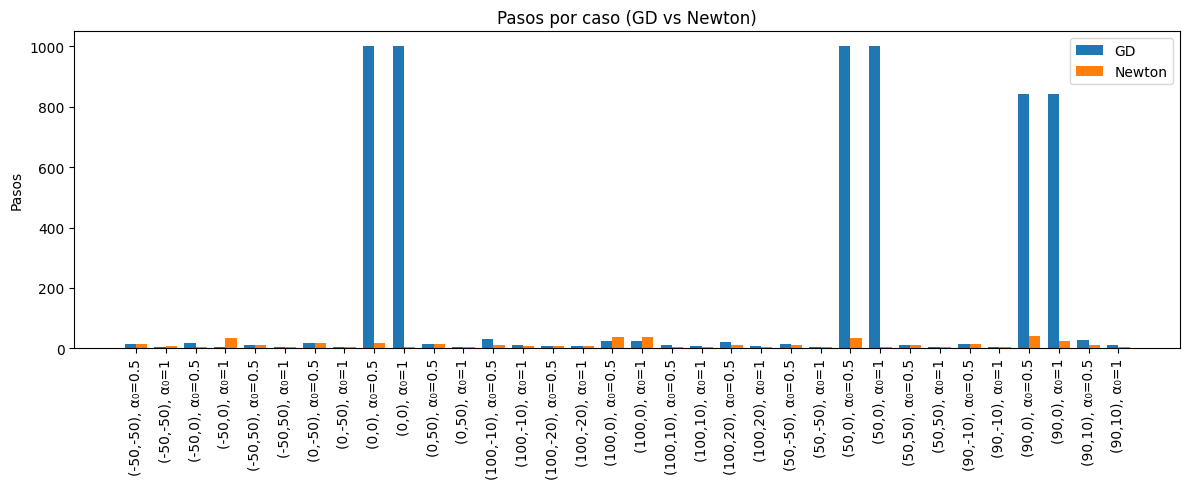

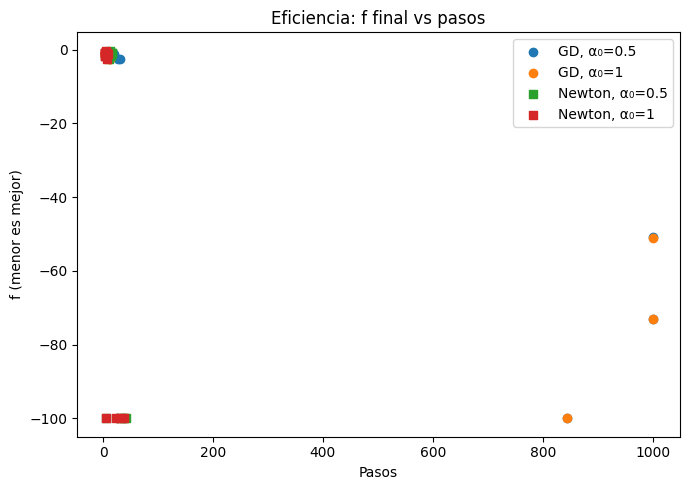

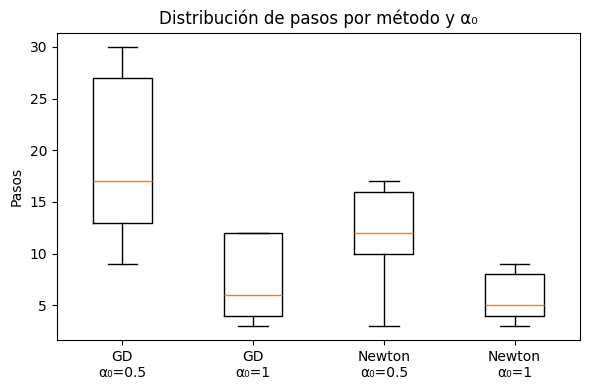

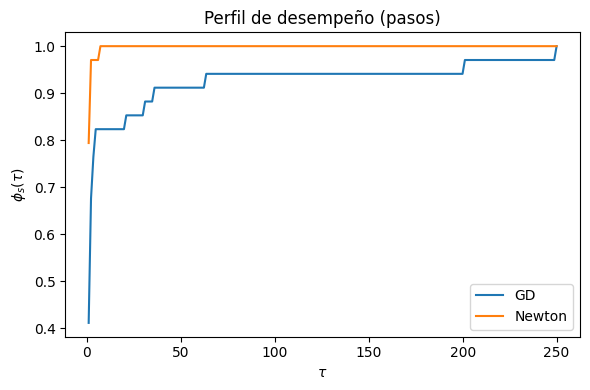

In [ ]:
import json, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

with open("resultados_gd.json", "r", encoding="utf-8") as f:
    gd_rows = json.load(f)["results"]
with open("resultados_newton.json", "r", encoding="utf-8") as f:
    nt_rows = json.load(f)["results"]

gd = pd.DataFrame(gd_rows).assign(metodo="GD")
nt = pd.DataFrame(nt_rows).assign(metodo="Newton")
df = pd.concat([gd, nt], ignore_index=True)

def fmt_start(s):
    x, y = s
    fx = int(x) if float(x).is_integer() else x
    fy = int(y) if float(y).is_integer() else y
    return f"({fx},{fy})"
df["inicio"] = df["start"].apply(fmt_start)
df["caso"] = df["inicio"] + r", α₀=" + df["alpha0"].map(lambda v: f"{v:g}")

# ---------- 1) Barras agrupadas de pasos por caso ----------
df_sorted = df.sort_values(["inicio","alpha0","metodo"])
casos = df_sorted["caso"].unique()

fig = plt.figure(figsize=(12, 5))
x = np.arange(len(casos))
width = 0.38
steps_gd = df_sorted[df_sorted["metodo"]=="GD"]["steps"].values
steps_nt = df_sorted[df_sorted["metodo"]=="Newton"]["steps"].values
plt.bar(x - width/2, steps_gd, width, label="GD")
plt.bar(x + width/2, steps_nt, width, label="Newton")
plt.xticks(x, casos, rotation=90)
plt.ylabel("Pasos")
plt.title("Pasos por caso (GD vs Newton)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_barras_pasos.png", dpi=180)

# ---------- 2) Dispersión f vs pasos ----------
fig = plt.figure(figsize=(7, 5))
markers = {"GD":"o", "Newton":"s"}
for (met, a0), sub in df.groupby(["metodo","alpha0"]):
    plt.scatter(sub["steps"], sub["f"], marker=markers[met], label=f"{met}, α₀={a0:g}")
plt.xlabel("Pasos")
plt.ylabel("f (menor es mejor)")
plt.title("Eficiencia: f final vs pasos")
plt.legend()
plt.tight_layout()
plt.savefig("fig_scatter_f_vs_pasos.png", dpi=180)

# ---------- 3) Boxplots de pasos por método y α₀ ----------
fig = plt.figure(figsize=(6, 4))
labels = []
data = []
for met in ["GD","Newton"]:
    for a0 in sorted(df["alpha0"].unique()):
        labels.append(f"{met}\nα₀={a0:g}")
        data.append(df[(df["metodo"]==met) & (df["alpha0"]==a0)]["steps"].values)
plt.boxplot(data, labels=labels, showfliers=False)
plt.ylabel("Pasos")
plt.title("Distribución de pasos por método y α₀")
plt.tight_layout()
plt.savefig("fig_box_steps.png", dpi=180)

# ---------- 4) Perfil de desempeño (Dolan–Moré) en pasos ----------
cases = sorted(set((r["inicio"], r["alpha0"]) for r in df.to_dict("records")))
solvers = ["GD","Newton"]

ratios = {s: [] for s in solvers}
for c in cases:
    sub = df[(df["inicio"]==c[0]) & (df["alpha0"]==c[1])]
    if len(sub) < 2:
        continue
    best = sub["steps"].min()
    for s in solvers:
        v = sub[sub["metodo"]==s]["steps"].values[0]
        ratios[s].append(v / best if best > 0 else np.inf)

taus = np.linspace(1, max([max(v) for v in ratios.values()]), 200)
fig = plt.figure(figsize=(6,4))
for s in solvers:
    arr = np.array(ratios[s], float)
    phi = [(arr <= t).mean() for t in taus]
    plt.plot(taus, phi, label=s)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\phi_s(\tau)$")
plt.title("Perfil de desempeño (pasos)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_perf_profile.png", dpi=180)

## Graficación de Algoritmos

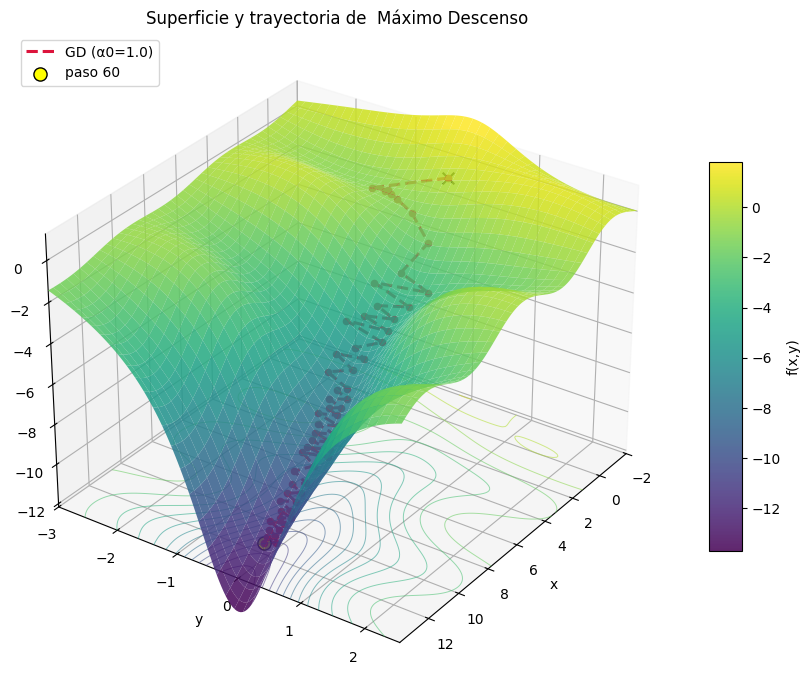

In [26]:
def plot_md_path(start=(0.0,0.0), alpha0=1.0, armijo_c=1e-4, armijo_rho=0.5,
                             xmin=None, xmax=None, ymin=None, ymax=None,
                             pad=2.0, num=160, elev=30, azim=35, show_tail=250,
                             kmax=None, highlight_k=None, marker_every=1, lift=0.0):
    """Parámetros:
        start      -- (x0,y0) inicial (para gradient_descent)
        alpha0     -- paso inicial (Armijo lo ajusta)
        kmax       -- plotea hasta ese paso (inclusive); None para toda la ruta/cola
        highlight_k-- resalta ese paso con marcador extra
        marker_every-- usa 1 de cada N puntos para marcadores
        lift       -- eleva la curva en z (añade 'lift' al z) para que no se pierda dentro de la superficie
    """
    res = max_descent(start, alpha0=alpha0, armijo_c=armijo_c, armijo_rho=armijo_rho)
    path = np.array(res.path) # lista completa de iteradores producida por el algoritmo 

    if kmax is not None:
        kmax = max(0, min(int(kmax), len(path)-1))
        path = path[:kmax+1]

    if show_tail is not None and len(path) > show_tail:
        path = path[-show_tail:]

    px_min, py_min = path[:,0].min(), path[:,1].min()
    px_max, py_max = path[:,0].max(), path[:,1].max()
    if xmin is None: xmin = px_min - pad
    if xmax is None: xmax = px_max + pad
    if ymin is None: ymin = py_min - pad
    if ymax is None: ymax = py_max + pad

    xs = np.linspace(xmin, xmax, num)
    ys = np.linspace(ymin, ymax, num)
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    Z = np.cos(X) * np.sin(Y) - X / (Y**2 + 1.0)  # superficie z=f(x,y)

    Zp = np.array([f_xy(px, py) for px, py in path])
    allZ = np.concatenate([Z.ravel(), Zp])
    zmin, zmax = np.quantile(allZ, 0.01), np.quantile(allZ, 0.99)

    if lift == 0.0:
        lift = 0.01 * max(1e-9, (zmax - zmin))
    Zp_line = Zp + lift  
    
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, cmap='viridis', edgecolor='none', alpha=0.85)
    ax.contour(X, Y, Z, zdir='z', offset=zmin, levels=15, cmap='viridis', alpha=0.55, linewidths=0.7)

    ax.plot(path[:,0], path[:,1], Zp_line, linestyle='--', linewidth=2.2, color='crimson', label=f'GD (α0={alpha0})', zorder=4)  # curva 3D de la trayectoria
    if marker_every is None or marker_every < 1:
        marker_every = 1
    pts = path[::marker_every]
    zp_pts = Zp_line[::marker_every]
    ax.scatter(pts[:,0], pts[:,1], zp_pts, s=20, color='crimson', depthshade=False, zorder=5)
    ax.scatter(path[0,0], path[0,1], Zp_line[0], s=70, marker='x', color='k', zorder=6)
    ax.scatter(path[-1,0], path[-1,1], Zp_line[-1], s=70, marker='*', edgecolor='k', color='white', zorder=6)

    if highlight_k is not None:
        hk = max(0, min(int(highlight_k), len(path)-1))
        ax.scatter(path[hk,0], path[hk,1], Zp_line[hk], s=90, marker='o', edgecolor='k', color='yellow', zorder=7, label=f'paso {hk}')

    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('f(x,y)')
    ax.set_title('Superficie y trayectoria de  Máximo Descenso')
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.05, label='f(x,y)')
    ax.legend(loc='upper left')
    plt.tight_layout(); plt.show()

# Ejemplo de uso:
plot_md_path(start=(0.0,0.0), alpha0=1.0, kmax=60, highlight_k=60)

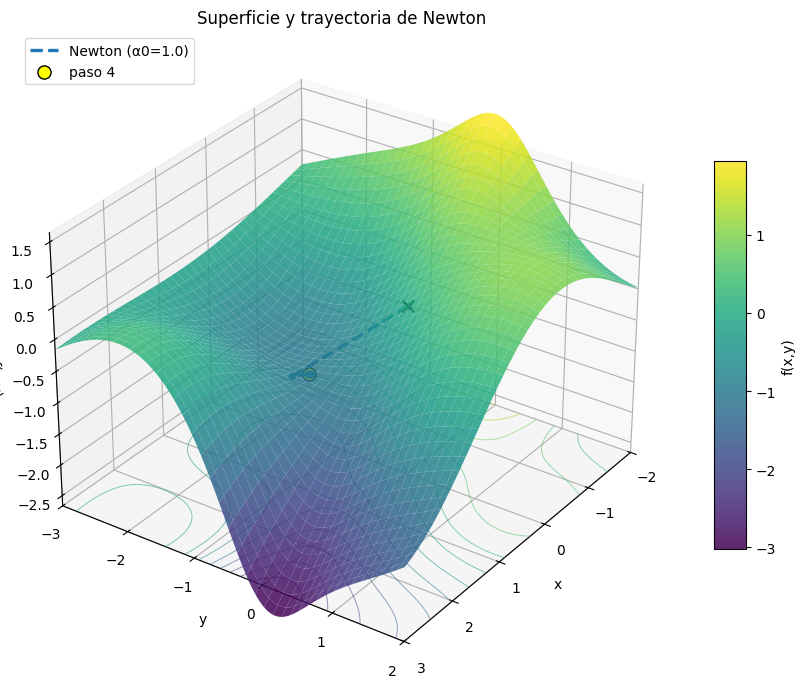

In [27]:
def plot_newton_path(start=(0.0,0.0), alpha0=1.0, armijo_c=1e-4, armijo_rho=0.5,
                               xmin=None, xmax=None, ymin=None, ymax=None,
                               pad=2.0, num=160, elev=30, azim=35, show_tail=250,
                               kmax=None, highlight_k=None, marker_every=1, lift=0.0):
    """Superficie 3D + trayectoria de Newton con control de visibilidad."""
    res = newton_method(start, alpha0=alpha0, armijo_c=armijo_c, armijo_rho=armijo_rho)
    path = np.array(res.path)
    if kmax is not None:
        kmax = max(0, min(int(kmax), len(path)-1))
        path = path[:kmax+1]
    if show_tail is not None and len(path) > show_tail:
        path = path[-show_tail:]
    px_min, py_min = path[:,0].min(), path[:,1].min()
    px_max, py_max = path[:,0].max(), path[:,1].max()
    if xmin is None: xmin = px_min - pad
    if xmax is None: xmax = px_max + pad
    if ymin is None: ymin = py_min - pad
    if ymax is None: ymax = py_max + pad

    xs = np.linspace(xmin, xmax, num)
    ys = np.linspace(ymin, ymax, num)
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    Z = np.cos(X) * np.sin(Y) - X / (Y**2 + 1.0)

    Zp = np.array([f_xy(px, py) for px, py in path])
    allZ = np.concatenate([Z.ravel(), Zp])
    zmin, zmax = np.quantile(allZ, 0.01), np.quantile(allZ, 0.99)
    if lift == 0.0:
        lift = 0.01 * max(1e-9, (zmax - zmin))
    Zp_line = Zp + lift

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, cmap='viridis', edgecolor='none', alpha=0.85)
    ax.contour(X, Y, Z, zdir='z', offset=zmin, levels=15, cmap='viridis', alpha=0.55, linewidths=0.7)

    ax.plot(path[:,0], path[:,1], Zp_line, linestyle='--', linewidth=2.4, color='tab:blue', label=f'Newton (α0={alpha0})', zorder=4)
    if marker_every is None or marker_every < 1:
        marker_every = 1
    pts = path[::marker_every]; zp_pts = Zp_line[::marker_every]
    ax.scatter(pts[:,0], pts[:,1], zp_pts, s=20, color='tab:blue', depthshade=False, zorder=5)
    ax.scatter(path[0,0], path[0,1], Zp_line[0], s=70, marker='x', color='k', zorder=6)
    ax.scatter(path[-1,0], path[-1,1], Zp_line[-1], s=70, marker='*', edgecolor='k', color='white', zorder=6)
    if highlight_k is not None:
        hk = max(0, min(int(highlight_k), len(path)-1))
        ax.scatter(path[hk,0], path[hk,1], Zp_line[hk], s=90, marker='o', edgecolor='k', color='yellow', zorder=7, label=f'paso {hk}')

    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('f(x,y)')
    ax.set_title('Superficie y trayectoria de Newton')
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.05, label='f(x,y)')
    ax.legend(loc='upper left')
    plt.tight_layout(); plt.show()

# Ejemplo de uso 
plot_newton_path(start=(0.0,0.0), alpha0=1.0, kmax=60, highlight_k=6)